In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def preprocessing_accident_dataframe(accident_df):
    accident_df['Data'] = pd.to_datetime(accident_df['Data'])
    accident_df['weekday'] = accident_df['Data'].dt.weekday.astype(str)
    accident_df.drop(columns='Data', inplace=True)
    return accident_df


In [116]:
def get_most_frequent_class(series):
    return series.value_counts().index.tolist()[0]

In [117]:
class DecisionTreeNode:
    def __init__(self):
        self.label = None
        self.decision = None
        self.alt_node = None
        self.type = None
        self.children = dict()
    
    def add_branch(self, value, node):
        self.children[value] = node
    
    def next_node(self, value):
        if value in self.children.keys():
            return self.children[value]
        return self.alt_node

    def _predict_one_record(self, record: dict):
        node = self
        while(True):

            if node.type == 'node':
                record_decision = record[node.decision]
                node = node.next_node(record_decision)

            if node.type == 'leaf':
                return node.label


    def predict(self, df):
        records = df.to_dict('records')
        predictions = [self._predict_one_record(record) for record in records]
        return pd.Series(predictions, index = df.index, name="decision_tree_pred")
    
    def __repr__(self):
        return f"type = {self.type}\ndecision = {self.decision}\nchildren = {list(self.children)}\nlabel={self.label}"

In [118]:
def entropy(examples, target_attribute):
   result = 0
   for value, subset in examples.groupby(target_attribute):
       proportion = len(subset)/len(examples)
       result -= proportion * np.log2(proportion)
   return result

In [119]:
def calculate_info_gain(examples, attribute, target_attribute, set_entropy):
   gain = set_entropy
   for value, subset in examples.groupby(attribute):
       gain -=  len(subset)/len(examples) * entropy(subset, target_attribute)
   return gain

In [120]:
def get_attr_with_most_info_gain(examples, attributes, target_attribute):
    set_entropy = entropy(examples, target_attribute)

    info_gains = []
    for attribute in attributes:
        info_gains.append((calculate_info_gain(examples, attribute, target_attribute, set_entropy), attribute))

    info_gains = sorted(info_gains, key = lambda x: x[0], reverse = True)
    return info_gains[0][1]
    

In [121]:
def id3 (examples: pd.DataFrame, attributes: list, target_attribute: str, min_examples_per_leaf: int = 2, depth = 0):
    node = DecisionTreeNode()
    attributes = attributes.copy()
    attrs_set = set(examples[target_attribute])
    # print(f'leaf: {attrs_set}')
    if  len(attrs_set) == 1:
        node.label = attrs_set.pop()
        node.type = 'leaf'
        return node

    if len(attributes) == 0 or len(examples) < min_examples_per_leaf:
        node.label = get_most_frequent_class(examples[target_attribute])
        node.type = 'leaf'
        return node

    best_attr = get_attr_with_most_info_gain(examples, attributes, target_attribute)
    
    node.decision = best_attr
    attributes.remove(best_attr)

    for value, subset in examples.groupby(best_attr):
        # print(" " * depth, best_attr, value)
        node.add_branch(value, id3(subset, attributes, target_attribute, min_examples_per_leaf, depth + 1))
        node.type = 'node'

    node.alt_node = DecisionTreeNode()
    node.alt_node.label = get_most_frequent_class(examples[target_attribute])
    node.alt_node.type = 'leaf'
    
    return node

In [129]:
accident_df = pd.read_csv("accident_data.csv")
accident_df = preprocessing_accident_dataframe(accident_df)

target_attribute = "Accident Level"
attributes = accident_df.columns.tolist()
attributes.remove(target_attribute)

accident_df.head()


,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico,weekday
0,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,4
1,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,5
2,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,2
3,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,4
4,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,6


In [ ]:
(54, 111),
(56, 437),
(56, 818),
(56, 937),
(57, 25),

In [329]:
df_train, df_test = train_test_split(accident_df, train_size=.8, random_state=45) # 25, 818

In [330]:
decision_tree = id3(df_train, attributes.copy(), target_attribute)

In [331]:
y_pred_apriori = pd.Series([get_most_frequent_class(df_train[target_attribute])] * len(df_test), index = df_test.index, name="apriori_pred")
y_pred_tree = decision_tree.predict(df_test)
y = df_test[target_attribute]
y.name = "real"

In [332]:
results = pd.concat([y, y_pred_apriori, y_pred_tree], axis = 1)

In [333]:
results.head()

,real,apriori_pred,decision_tree_pred
197,II,I,II
400,III,I,III
411,I,I,I
328,I,I,I
239,I,I,I


In [334]:
def accuracy(y, y_pred):
    return sum(y == y_pred) / len(y)

In [335]:
accuracy(results['real'], results['decision_tree_pred'])

0.7272727272727273

In [336]:
accuracy(results['real'], results['apriori_pred'])

0.6590909090909091

Text(33.0, 0.5, 'real')

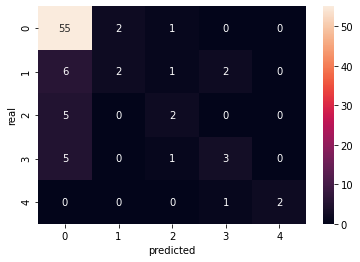

In [348]:
sns.heatmap(confusion_matrix(results['real'], results['decision_tree_pred'], labels = [ 'I', 'II', 'III', 'IV', 'V']), annot=True)
plt.xlabel("predicted")
plt.ylabel("real")

Text(33.0, 0.5, 'real')

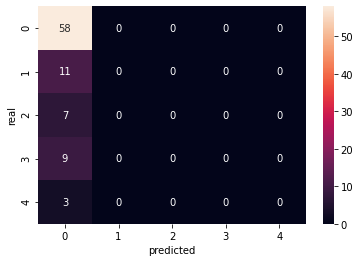

In [349]:
sns.heatmap(confusion_matrix(results['real'], results['apriori_pred'],  labels = [ 'I', 'II', 'III', 'IV', 'V']), annot=True)
plt.xlabel("predicted")
plt.ylabel("real")

In [316]:
def roman2dec(x):
    if x == 'I':
        return 1
    if x == 'II':
        return 2
    if x == 'III':
        return 3
    if x == 'IV':
        return 4
    if x == 'V':
        return 5

In [317]:
mean_squared_error(results['real'].apply(roman2dec), results['decision_tree_pred'].apply(roman2dec))

1.0

In [318]:
mean_squared_error(results['real'].apply(roman2dec), results['apriori_pred'].apply(roman2dec))

1.9090909090909092

In [319]:
cohen_kappa_score(results['real'], results['decision_tree_pred'])

0.3943217665615142

In [320]:
cohen_kappa_score(results['real'], results['apriori_pred'])

0.0